# 期末類別型資料分析

C111156103, 潘奕濬


## 環境設定


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib_inline

plt.rcParams["font.sans-serif"] = ["Arial Unicode MS"]
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

## Import data from UCI machine learning repository


In [3]:
# fetch dataset
mushroom = fetch_ucirepo(id=73)

# data (as pandas dataframes)
assert mushroom.data is not None
assert isinstance(mushroom.data.features, pd.DataFrame)
assert isinstance(mushroom.data.targets, pd.DataFrame)

X = mushroom.data.features
y = mushroom.data.targets

In [4]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.to_numpy().ravel())

## 切割資料集與訓練集

訓練級是用來回測的。


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [6]:
import seaborn as sns
import numpy as np

# 基本資料資訊
print("=== 資料集基本資訊 ===")
print(f"樣本數：{len(X)}")
print(f"特徵數：{X.shape[1]}")
print(f"目標變數類別：{np.unique(y_encoded)}")
print(f"類別分布：")
print(pd.Series(y_encoded).value_counts().sort_index())

print("\n=== 資料類型 ===")
print(X.dtypes.value_counts())

print("\n=== 缺失值統計 ===")
missing_values = X.isnull().sum()
print(f"有缺失值的欄位數：{(missing_values > 0).sum()}")
if (missing_values > 0).any():
    print("缺失值統計：")
    print(missing_values[missing_values > 0])
else:
    print("無缺失值")


=== 資料集基本資訊 ===
樣本數：8124
特徵數：22
目標變數類別：[0 1]
類別分布：
0    4208
1    3916
Name: count, dtype: int64

=== 資料類型 ===
object    22
Name: count, dtype: int64

=== 缺失值統計 ===
有缺失值的欄位數：1
缺失值統計：
stalk-root    2480
dtype: int64


In [7]:
# 將分類變數轉換為數值進行統計分析
from sklearn.preprocessing import LabelEncoder

# 為每個分類變數建立標籤編碼器
X_encoded = X.copy()
encoders = {}

for col in X.columns:
    if X[col].dtype == "object":
        encoders[col] = LabelEncoder()
        X_encoded[col] = encoders[col].fit_transform(X[col])

print("=== 數值化後的敘述統計 ===")
desc_stats = X_encoded.describe()
print(desc_stats)

print("\n=== 變異數 ===")
variance_stats = X_encoded.var()
print(variance_stats.describe())


=== 數值化後的敘述統計 ===
         cap-shape  cap-surface    cap-color      bruises         odor  \
count  8124.000000  8124.000000  8124.000000  8124.000000  8124.000000   
mean      3.348104     1.827671     4.504677     0.415559     4.144756   
std       1.604329     1.229873     2.545821     0.492848     2.103729   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       2.000000     0.000000     3.000000     0.000000     2.000000   
50%       3.000000     2.000000     4.000000     0.000000     5.000000   
75%       5.000000     3.000000     8.000000     1.000000     5.000000   
max       5.000000     3.000000     9.000000     1.000000     8.000000   

       gill-attachment  gill-spacing    gill-size   gill-color  stalk-shape  \
count      8124.000000   8124.000000  8124.000000  8124.000000  8124.000000   
mean          0.974151      0.161497     0.309207     4.810684     0.567208   
std           0.158695      0.368011     0.462195     3.540359     0.495493   

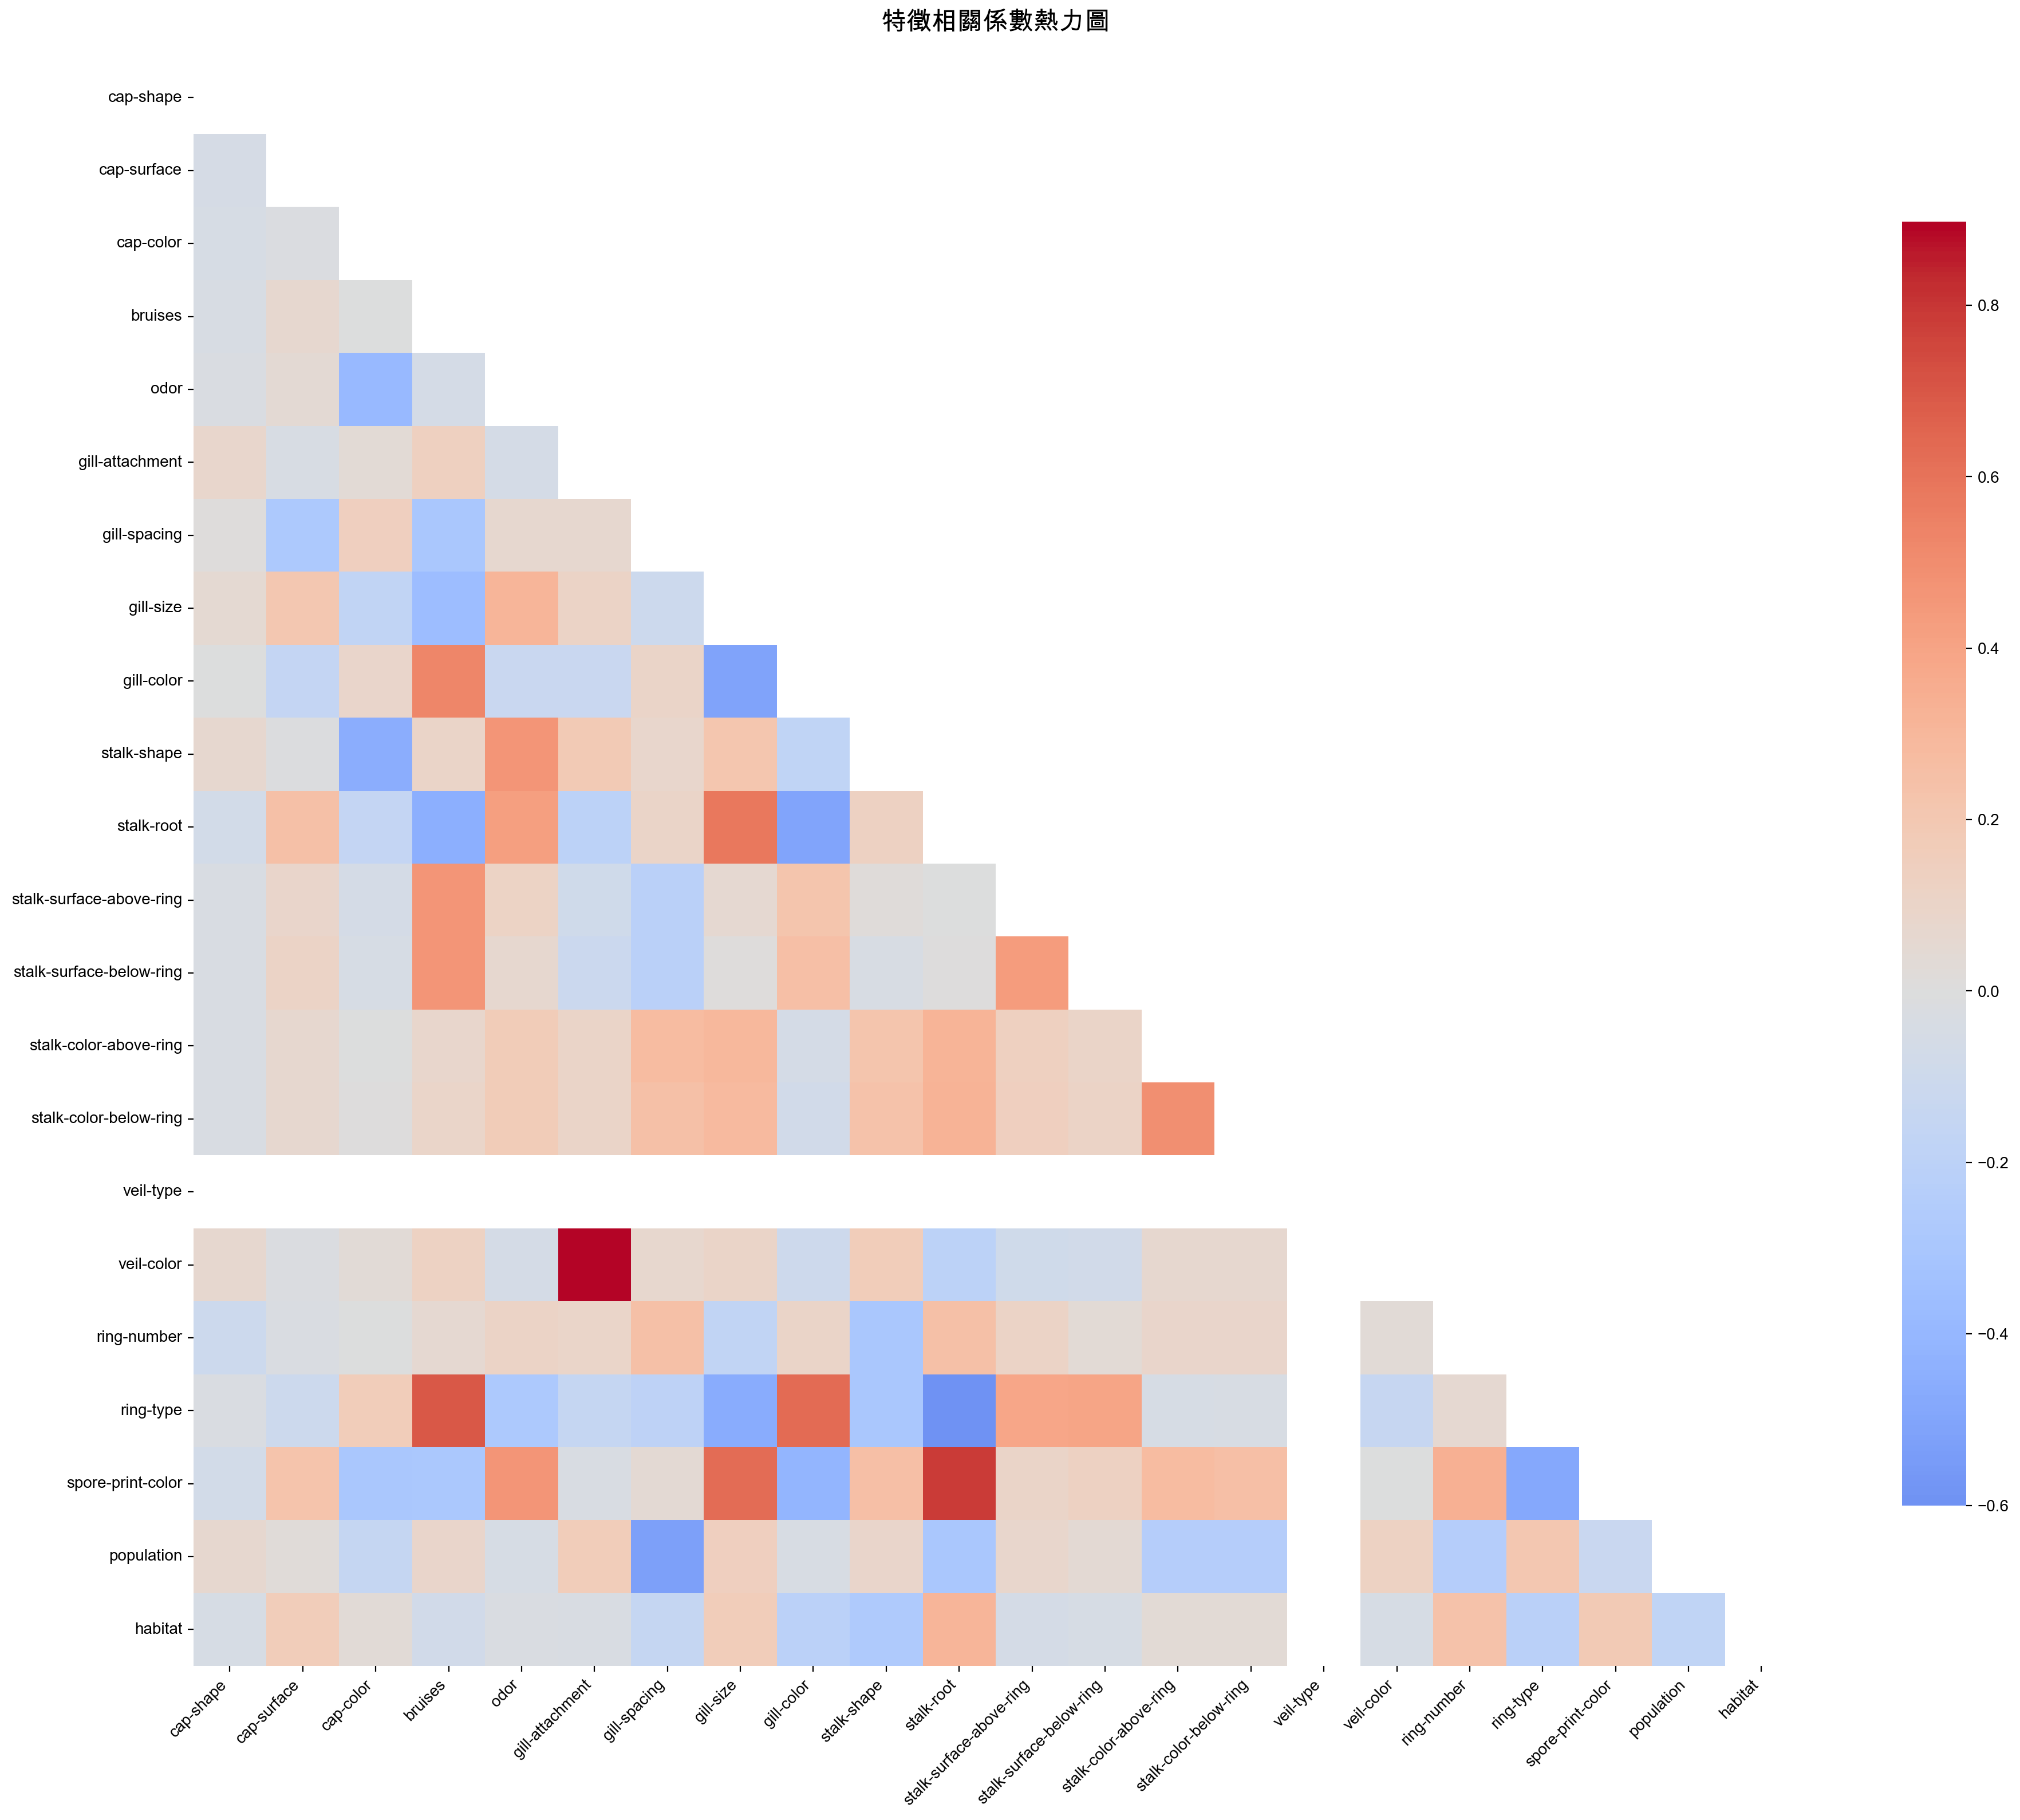

相關係數統計摘要：
相關係數範圍：nan 到 nan
平均相關係數：nan
相關係數標準差：nan

高相關性特徵對 (|r| > 0.5)：11 對
bruises vs gill-color: 0.527
bruises vs ring-type: 0.693
gill-attachment vs veil-color: 0.898
gill-spacing vs population: -0.529
gill-size vs gill-color: -0.517
gill-size vs stalk-root: 0.586
gill-size vs spore-print-color: 0.623
gill-color vs stalk-root: -0.504
gill-color vs ring-type: 0.629
stalk-root vs ring-type: -0.600


In [8]:
# 相關係數熱力圖
plt.figure(figsize=(20, 16))
correlation_matrix = X_encoded.corr()

# 建立遮罩來只顯示下三角
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# 繪製熱力圖
sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=False,  # 因為特徵太多，不顯示數值
    cmap="coolwarm",
    center=0,
    square=True,
    fmt=".2f",
    cbar_kws={"shrink": 0.8},
)

plt.title("特徵相關係數熱力圖", fontsize=16, pad=20)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("相關係數統計摘要：")
# 取得相關係數的分布情況
corr_values = correlation_matrix.values
# 移除對角線元素（自相關=1）
corr_values = corr_values[~np.eye(corr_values.shape[0], dtype=bool)]
print(f"相關係數範圍：{corr_values.min():.3f} 到 {corr_values.max():.3f}")
print(f"平均相關係數：{corr_values.mean():.3f}")
print(f"相關係數標準差：{corr_values.std():.3f}")

# 找出高相關性的特徵對
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:  # 閾值設為0.5
            high_corr_pairs.append(
                (correlation_matrix.columns[i], correlation_matrix.columns[j], corr_val)
            )

print(f"\n高相關性特徵對 (|r| > 0.5)：{len(high_corr_pairs)} 對")
for pair in high_corr_pairs[:10]:  # 只顯示前10對
    print(f"{pair[0]} vs {pair[1]}: {pair[2]:.3f}")


選擇前8個特徵進行散點圖矩陣分析：['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size']


<Figure size 1600x1200 with 0 Axes>

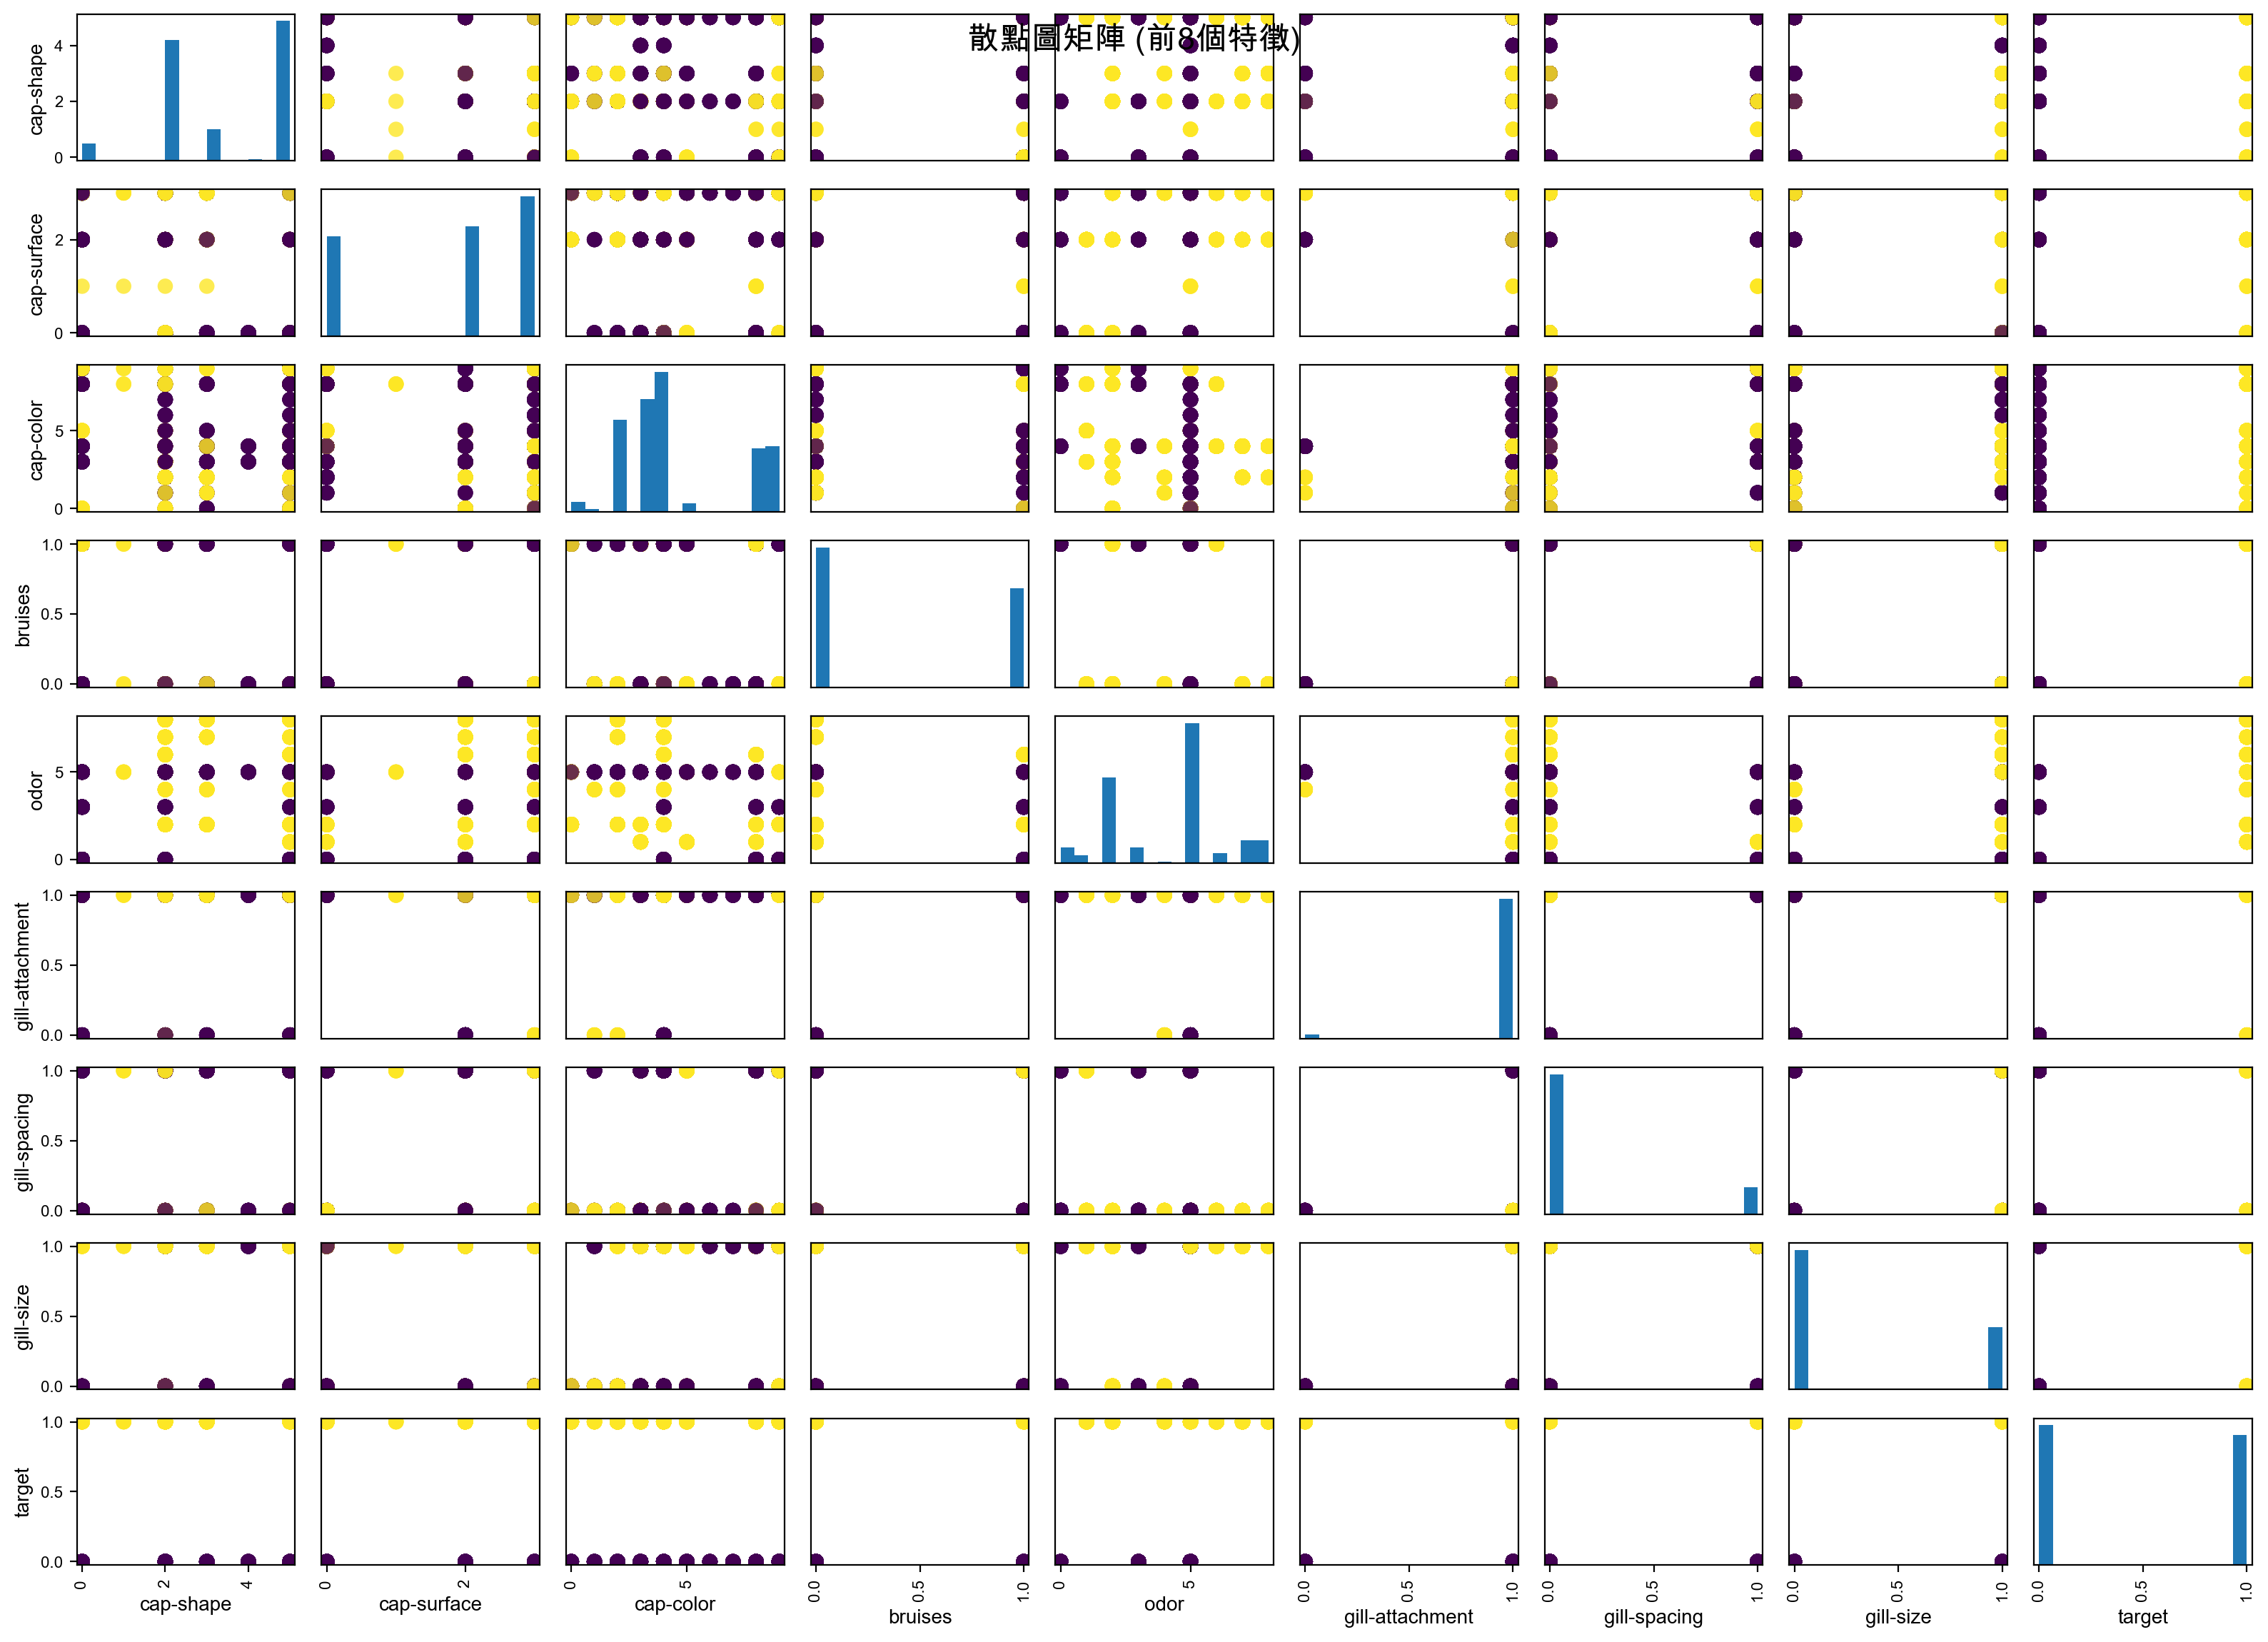


=== 特徵與目標變數的相關性 ===
與目標變數相關性最高的前10個特徵：
 1. gill-size:  0.540
 2. gill-color: -0.531
 3. bruises: -0.502
 4. ring-type: -0.412
 5. gill-spacing: -0.348
 6. stalk-surface-above-ring: -0.335
 7. stalk-surface-below-ring: -0.299
 8. population:  0.299
 9. habitat:  0.217
10. ring-number: -0.214

與目標變數相關性最低的5個特徵：
 1. stalk-shape: -0.102
 2. odor: -0.094
 3. cap-shape:  0.053
 4. cap-color: -0.031
 5. veil-type:    nan


/Volumes/Dev/nkust/nkust-homework/semester-6/machine-learning/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Volumes/Dev/nkust/nkust-homework/semester-6/machine-learning/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [9]:
# 散點圖矩陣 - 選擇前8個特徵進行展示（因為特徵太多）
selected_features = X_encoded.columns[:8]
selected_data = X_encoded[selected_features].copy()
selected_data["target"] = y_encoded

print(f"選擇前8個特徵進行散點圖矩陣分析：{list(selected_features)}")

# 建立散點圖矩陣
plt.figure(figsize=(16, 12))
pd.plotting.scatter_matrix(
    selected_data,
    c=selected_data["target"],
    figsize=(16, 12),
    marker="o",
    hist_kwds={"bins": 15},
    s=60,
    alpha=0.8,
    diagonal="hist",
)

plt.suptitle("散點圖矩陣 (前8個特徵)", fontsize=16, y=0.95)
plt.tight_layout()
plt.show()

# 特徵與目標變數的相關性
print("\n=== 特徵與目標變數的相關性 ===")
target_corr = X_encoded.corrwith(pd.Series(y_encoded))
target_corr_sorted = target_corr.abs().sort_values(ascending=False)

print("與目標變數相關性最高的前10個特徵：")
for i, (feature, corr) in enumerate(target_corr_sorted.head(10).items(), 1):
    print(f"{i:2d}. {feature}: {target_corr[feature]:6.3f}")

print(f"\n與目標變數相關性最低的5個特徵：")
for i, (feature, corr) in enumerate(target_corr_sorted.tail(5).items(), 1):
    print(f"{i:2d}. {feature}: {target_corr[feature]:6.3f}")


## Pre-Processing


In [10]:
from typing import Literal, Self
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin


class DropNullColumns(BaseEstimator, TransformerMixin):
    transform_type: None | Literal["default", "pandas"]

    def __init__(self, columns: list[str] | None = None):
        self.columns = columns
        self.transform_type = None

    def fit(self, X: pd.DataFrame, _: pd.Series | None = None) -> Self:
        self.null_columns = X.columns[X.isnull().any()]
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame | np.ndarray:
        dropped_X = X.drop(columns=self.null_columns)

        if self.transform_type == "pandas":
            return dropped_X
        else:
            return dropped_X.to_numpy()

    def set_output(
        self, *, transform: None | Literal["default", "pandas"] = None
    ) -> BaseEstimator:
        self.transform_type = transform
        return self


preprocessor = Pipeline(
    [
        # 缺失值處理
        ("drop_cols", DropNullColumns()),
        (
            "encode",
            ColumnTransformer(
                [
                    # label encoding for binary data
                    (
                        "binary",
                        OrdinalEncoder(),
                        [
                            "bruises",
                            "gill-attachment",
                            "gill-spacing",
                            "gill-size",
                            "stalk-shape",
                        ],
                    ),
                    # one-hot encoding for non-binary data
                    (
                        "onehot",
                        OneHotEncoder(dtype="int64", sparse_output=False),
                        [
                            "cap-shape",
                            "cap-surface",
                            "cap-color",
                            "odor",
                            "gill-color",
                            "stalk-surface-above-ring",
                            "stalk-surface-below-ring",
                            "stalk-color-above-ring",
                            "stalk-color-below-ring",
                            "veil-color",
                            "ring-number",
                            "ring-type",
                            "spore-print-color",
                            "population",
                            "habitat",
                        ],
                    ),
                ],
                n_jobs=-1,
            ),
        ),
        (
            "lda",
            LinearDiscriminantAnalysis(n_components=1),
        ),
        ("standardize", StandardScaler()),
    ],
)

preprocessor.set_output(transform="pandas")
preprocessor

Pipeline(steps=[('drop_cols', DropNullColumns()),
                ('encode',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('binary', OrdinalEncoder(),
                                                  ['bruises', 'gill-attachment',
                                                   'gill-spacing', 'gill-size',
                                                   'stalk-shape']),
                                                 ('onehot',
                                                  OneHotEncoder(dtype='int64',
                                                                sparse_output=False),
                                                  ['cap-shape', 'cap-surface',
                                                   'cap-color', 'odor',
                                                   'gill-color',
                                                   'stalk-surface-above-ring',
                                                   'stalk-surface-below-ring',
                                                   'stalk-color-above-ring',
                                                   'stalk-color-below-ring',
                                                   'veil-color', 'ring-number',
                                                   'ring-type',
                                                   'spore-print-color',
                                                   'population',
                                                   'habitat'])])),
                ('lda', LinearDiscriminantAnalysis(n_components=1)),
                ('standardize', StandardScaler())])

In [11]:
X_train_pp = preprocessor.fit_transform(X_train, y_train)
X_test_pp = preprocessor.transform(X_test)

## 建立模型

實作完整的八種機器學習算法：LR、DT、RF、SVM、KNN、XGB、Bagging、AdaBoost

### 算法說明：

1. **LR (Logistic Regression)**: 邏輯回歸，線性分類器
2. **DT (Decision Tree)**: 決策樹，基於樹狀結構的分類器
3. **RF (Random Forest)**: 隨機森林，多個決策樹的集成學習
4. **SVM (Support Vector Machine)**: 支持向量機，基於核函數的分類器
5. **KNN (K-Nearest Neighbors)**: K 最近鄰，基於距離的分類器
6. **XGB (XGBoost)**: 極端梯度提升，基於梯度提升的集成學習
7. **Bagging**: 裝袋法，多個弱學習器的並行集成
8. **AdaBoost**: 自適應提升，多個弱學習器的串行集成

### 參數設定：

- DT 使用之前 GridSearchCV 找出的最佳參數：`{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}`
- RF 使用之前 GridSearchCV 找出的最佳參數：`{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}`
- SVM 使用 RBF 核函數，開啟概率預測
- KNN 使用 k=5，uniform 權重
- XGBoost 使用默認參數，添加 eval_metric='logloss'
- Bagging 和 AdaBoost 都以決策樹為基學習器

### KFold 設定：

- 使用 K-Fold 交叉驗證來獲得更穩健的模型性能評估，減少因為特定訓練/測試集分割造成的偏差。
- 採 5 折

### 環境要求：

- macOS 需要安裝 `libomp` 才能執行 XGBoost：`brew install libomp`


In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier  # brew install libomp
from sklearn.model_selection import cross_val_score

assert X_train_pp is not None
assert isinstance(X_train_pp, pd.DataFrame)


# 最佳參數設定
dt_best_params = {
    "criterion": "gini",
    "max_depth": None,
    "min_samples_leaf": 1,
    "min_samples_split": 10,
}
rf_best_params = {
    "max_depth": None,
    "min_samples_leaf": 1,
    "min_samples_split": 5,
    "n_estimators": 100,
}

# 建立分類器實例
lr_classifier = LogisticRegression(random_state=42, max_iter=1000, solver="liblinear")
dt_classifier = DecisionTreeClassifier(random_state=42, **dt_best_params)
rf_classifier = RandomForestClassifier(random_state=42, **rf_best_params)
svm_classifier = SVC(
    random_state=42, probability=True, kernel="rbf", C=1.0, gamma="scale"
)
knn_classifier = KNeighborsClassifier(
    n_neighbors=5, weights="uniform", algorithm="auto"
)
xgb_classifier = XGBClassifier(random_state=42, eval_metric="logloss")
bagging_classifier = BaggingClassifier(
    estimator=dt_classifier, random_state=42, n_estimators=10
)
adaboost_classifier = AdaBoostClassifier(
    estimator=dt_classifier, random_state=42, n_estimators=50, learning_rate=1.0
)

# 所有算法列表
algorithms = [
    lr_classifier,
    dt_classifier,
    rf_classifier,
    svm_classifier,
    knn_classifier,
    xgb_classifier,
    bagging_classifier,
    adaboost_classifier,
]

classifiers: dict[str, Pipeline] = {}

cv = 10

for algorithm in algorithms:
    # 每個 model 結尾都有 Classifier，這個我們需要移除掉
    model_name = algorithm.__class__.__name__
    if model_name.endswith("Classifier"):
        model_name = model_name[: -len("Classifier")]

    # 特殊處理一些模型名稱
    if model_name == "LogisticRegression":
        model_name = "LR"
    elif model_name == "SVC":
        model_name = "SVM"
    elif model_name == "KNeighbors":
        model_name = "KNN"
    elif model_name == "XGB":
        model_name = "XGBoost"

    algorithm.fit(X_train_pp, y_train)

    scores = cross_val_score(
        algorithm,
        X_train_pp.to_numpy(),
        y_train,
        cv=cv,
        scoring="accuracy",
        error_score="raise",
    )
    print(
        f"{model_name} 在 train set 的 {cv=} 準確率：{scores.mean():.4f} ± {scores.std():.4f}"
    )
    classifiers[model_name] = algorithm


LR 在 train set 的 cv=10 準確率：0.9998 ± 0.0005
DecisionTree 在 train set 的 cv=10 準確率：0.9998 ± 0.0005
RandomForest 在 train set 的 cv=10 準確率：0.9998 ± 0.0005
SVM 在 train set 的 cv=10 準確率：0.9998 ± 0.0005
KNN 在 train set 的 cv=10 準確率：0.9998 ± 0.0005
XGBoost 在 train set 的 cv=10 準確率：0.9985 ± 0.0024
Bagging 在 train set 的 cv=10 準確率：0.9998 ± 0.0005
AdaBoost 在 train set 的 cv=10 準確率：0.9998 ± 0.0005


## 針對每個模型做混淆矩陣


In [13]:
from sklearn.metrics import confusion_matrix

confusion_matrixes = {
    name: confusion_matrix(y_test, algorithm.predict(X_test_pp))
    for name, algorithm in classifiers.items()
}

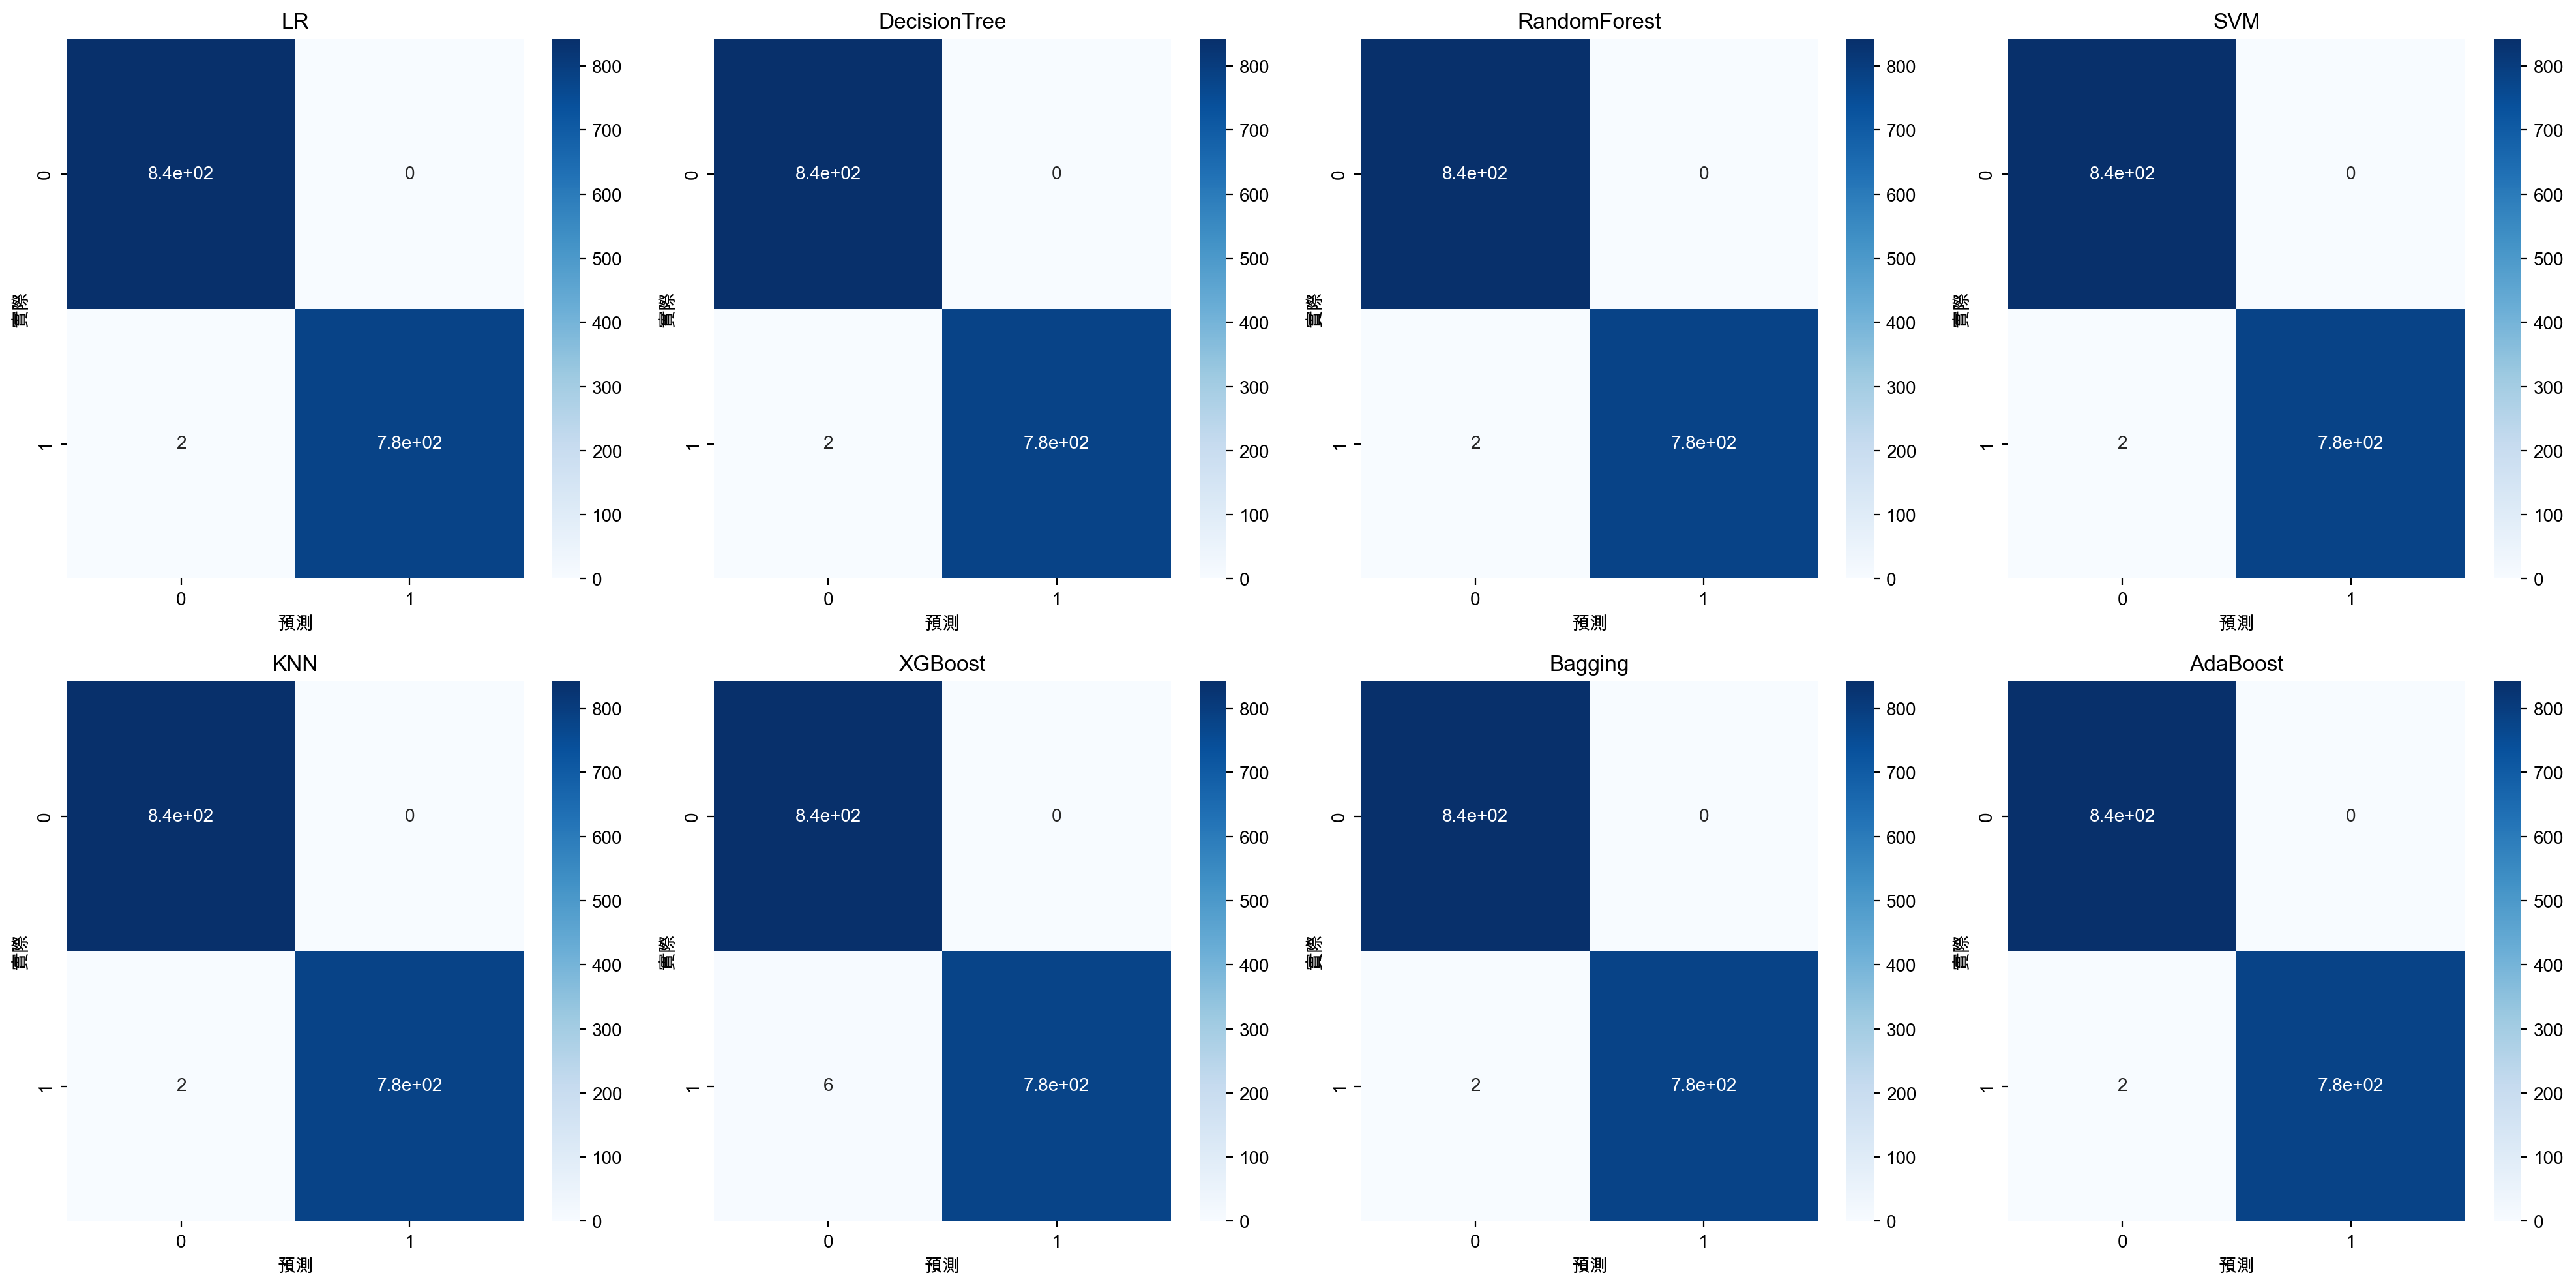

In [14]:
import seaborn as sns

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

for idx, (name, matrix) in enumerate(confusion_matrixes.items()):
    row = idx // 4
    col = idx % 4
    sns.heatmap(matrix, annot=True, cmap="Blues", ax=ax[row, col])
    ax[row, col].set_title(name)
    ax[row, col].set_xlabel("預測")
    ax[row, col].set_ylabel("實際")

fig.tight_layout()
plt.show()


## 測出 Accuracy、Precision、Recall 和 F1


In [15]:
from sklearn.metrics import (
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    accuracy_score,
    roc_auc_score,
)
from imblearn.metrics import specificity_score

scorers = {
    "Accuracy": make_scorer(accuracy_score),
    "Precision": make_scorer(precision_score),
    "Recall": make_scorer(recall_score),
    "Specificity": make_scorer(specificity_score),
    "F1": make_scorer(f1_score),
    "AUC": make_scorer(roc_auc_score),
}

scores = [
    {
        "Model": name,
        **{
            scorer_name: scorer(classifier, X_test_pp, y_test)
            for scorer_name, scorer in scorers.items()
        },
    }
    for name, classifier in classifiers.items()
]

results_df = pd.DataFrame(scores)
results_df.sort_values(by="Accuracy", ascending=False, inplace=True)
results_df.set_index("Model", inplace=True)

results_df

,Accuracy,Precision,Recall,Specificity,F1,AUC
Model,,,,,,
LR,0.998769,1.0,0.997446,1.0,0.998721,0.998723
DecisionTree,0.998769,1.0,0.997446,1.0,0.998721,0.998723
RandomForest,0.998769,1.0,0.997446,1.0,0.998721,0.998723
SVM,0.998769,1.0,0.997446,1.0,0.998721,0.998723
KNN,0.998769,1.0,0.997446,1.0,0.998721,0.998723
Bagging,0.998769,1.0,0.997446,1.0,0.998721,0.998723
AdaBoost,0.998769,1.0,0.997446,1.0,0.998721,0.998723
XGBoost,0.996308,1.0,0.992337,1.0,0.996154,0.996169


## ROC 曲線與 AUC


In [16]:
import matplotlib.pyplot as plt
import matplotlib_inline

plt.rcParams["font.sans-serif"] = ["Arial Unicode MS"]
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [17]:
from sklearn.model_selection import cross_validate
import warnings

warnings.filterwarnings("ignore")

# 定義評估指標
scoring_metrics = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc",
}

# 進行交叉驗證
cv_results = {}

print("正在進行 K-Fold 交叉驗證...")
for name, classifier in classifiers.items():
    print(f"正在評估 {name}...")

    # 進行交叉驗證
    cv_scores = cross_validate(
        classifier,
        X_train_pp.to_numpy(),
        y_train,
        cv=10,  # 使用10折交叉驗證
        scoring=scoring_metrics,
        return_train_score=True,
        n_jobs=-1,
    )

    # 儲存結果
    cv_results[name] = {
        "Test_Accuracy_Mean": cv_scores["test_accuracy"].mean(),
        "Test_Accuracy_Std": cv_scores["test_accuracy"].std(),
        "Test_Precision_Mean": cv_scores["test_precision"].mean(),
        "Test_Precision_Std": cv_scores["test_precision"].std(),
        "Test_Recall_Mean": cv_scores["test_recall"].mean(),
        "Test_Recall_Std": cv_scores["test_recall"].std(),
        "Test_F1_Mean": cv_scores["test_f1"].mean(),
        "Test_F1_Std": cv_scores["test_f1"].std(),
        "Test_ROC_AUC_Mean": cv_scores["test_roc_auc"].mean(),
        "Test_ROC_AUC_Std": cv_scores["test_roc_auc"].std(),
        "Train_Accuracy_Mean": cv_scores["train_accuracy"].mean(),
        "Train_Accuracy_Std": cv_scores["train_accuracy"].std(),
    }

print("交叉驗證完成！")


正在進行 K-Fold 交叉驗證...
正在評估 LR...
正在評估 DecisionTree...
正在評估 RandomForest...
正在評估 SVM...
正在評估 KNN...
正在評估 XGBoost...
正在評估 Bagging...
正在評估 AdaBoost...
交叉驗證完成！


In [18]:
# 建立交叉驗證結果DataFrame
cv_results_df = pd.DataFrame(cv_results).T

# 重新排列列的順序，讓結果更易讀
column_order = [
    "Train_Accuracy_Mean",
    "Train_Accuracy_Std",
    "Test_Accuracy_Mean",
    "Test_Accuracy_Std",
    "Test_Precision_Mean",
    "Test_Precision_Std",
    "Test_Recall_Mean",
    "Test_Recall_Std",
    "Test_F1_Mean",
    "Test_F1_Std",
    "Test_ROC_AUC_Mean",
    "Test_ROC_AUC_Std",
]

cv_results_df = cv_results_df[column_order]

# 根據測試集準確率排序
cv_results_df = cv_results_df.sort_values("Test_Accuracy_Mean", ascending=False)

print("=== K-Fold 交叉驗證結果匯總表 (K=10) ===")
print(cv_results_df.round(4))

# 儲存到CSV
cv_results_df.round(4).to_csv("cross_validation_results.csv")
print(f"\n結果已儲存至 cross_validation_results.csv")


=== K-Fold 交叉驗證結果匯總表 (K=10) ===
              Train_Accuracy_Mean  Train_Accuracy_Std  Test_Accuracy_Mean  \
LR                         0.9998              0.0001              0.9998   
DecisionTree               0.9998              0.0001              0.9998   
RandomForest               0.9998              0.0001              0.9998   
SVM                        0.9998              0.0001              0.9998   
KNN                        0.9998              0.0001              0.9998   
Bagging                    0.9998              0.0001              0.9998   
AdaBoost                   0.9998              0.0001              0.9998   
XGBoost                    0.9986              0.0001              0.9985   

              Test_Accuracy_Std  Test_Precision_Mean  Test_Precision_Std  \
LR                       0.0005                  1.0                 0.0   
DecisionTree             0.0005                  1.0                 0.0   
RandomForest             0.0005               

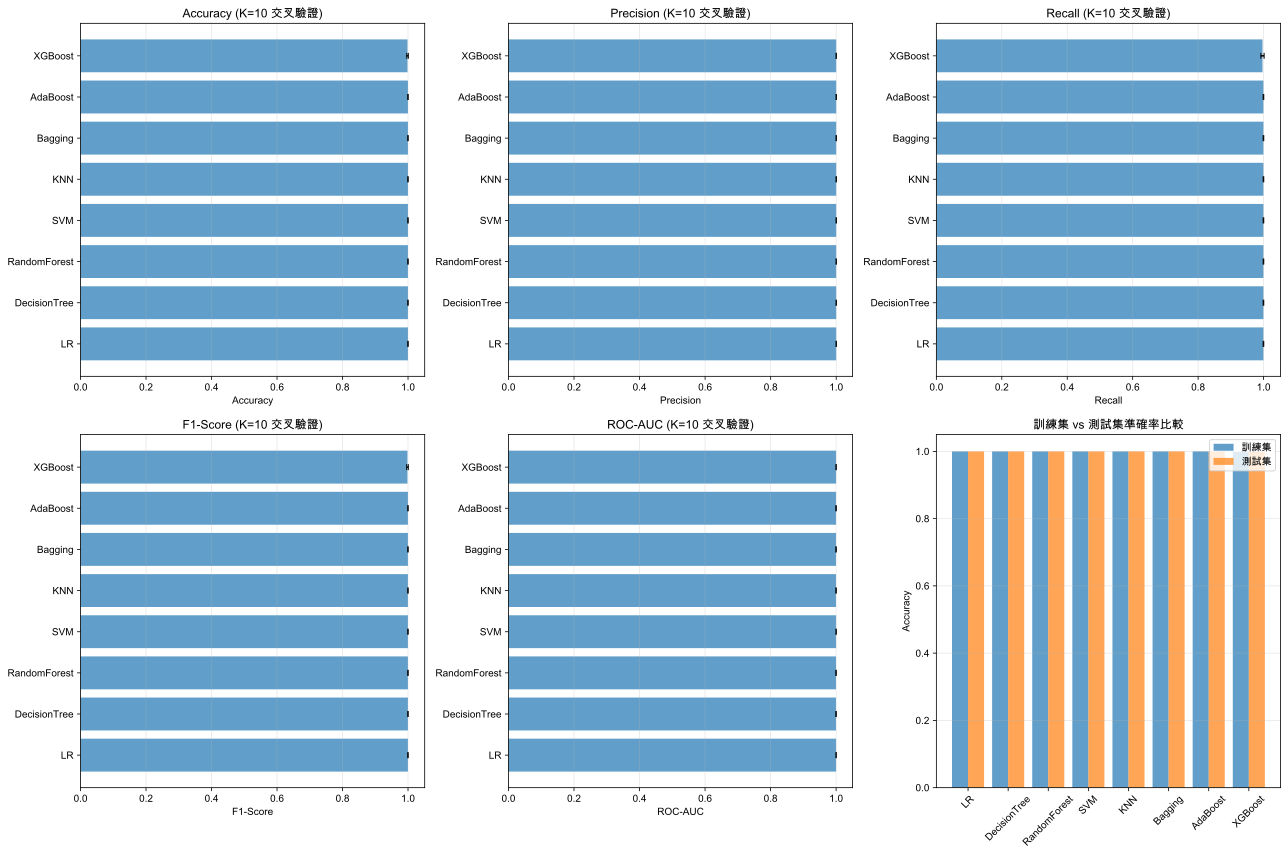


=== 交叉驗證統計摘要 ===
平均測試準確率：0.9997
測試準確率標準差：0.0005
最佳模型：LR (準確率：0.9998)
表現差異最小的指標：Precision

=== 過擬合檢查 ===
訓練集與測試集準確率差異：
LR: -0.0000
DecisionTree: -0.0000
RandomForest: -0.0000
SVM: -0.0000
KNN: -0.0000
Bagging: -0.0000
AdaBoost: -0.0000
XGBoost: 0.0002
平均差異：0.0000


In [19]:
# 視覺化交叉驗證結果
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

metrics = [
    "Test_Accuracy_Mean",
    "Test_Precision_Mean",
    "Test_Recall_Mean",
    "Test_F1_Mean",
    "Test_ROC_AUC_Mean",
]
metric_names = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]

for i, (metric, name) in enumerate(zip(metrics, metric_names)):
    if i < len(axes) - 1:  # 前5個圖用於指標
        std_metric = metric.replace("_Mean", "_Std")

        y_pos = np.arange(len(cv_results_df))
        axes[i].barh(
            y_pos,
            cv_results_df[metric],
            xerr=cv_results_df[std_metric],
            capsize=3,
            alpha=0.7,
        )
        axes[i].set_yticks(y_pos)
        axes[i].set_yticklabels(cv_results_df.index)
        axes[i].set_xlabel(name)
        axes[i].set_title(f"{name} (K=10 交叉驗證)")
        axes[i].grid(axis="x", alpha=0.3)

# 最後一個子圖顯示訓練vs測試準確率比較
axes[5].bar(
    np.arange(len(cv_results_df)) - 0.2,
    cv_results_df["Train_Accuracy_Mean"],
    width=0.4,
    label="訓練集",
    alpha=0.7,
)
axes[5].bar(
    np.arange(len(cv_results_df)) + 0.2,
    cv_results_df["Test_Accuracy_Mean"],
    width=0.4,
    label="測試集",
    alpha=0.7,
)
axes[5].set_xticks(np.arange(len(cv_results_df)))
axes[5].set_xticklabels(cv_results_df.index, rotation=45)
axes[5].set_ylabel("Accuracy")
axes[5].set_title("訓練集 vs 測試集準確率比較")
axes[5].legend()
axes[5].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

# 統計摘要
print("\n=== 交叉驗證統計摘要 ===")
print(f"平均測試準確率：{cv_results_df['Test_Accuracy_Mean'].mean():.4f}")
print(f"測試準確率標準差：{cv_results_df['Test_Accuracy_Mean'].std():.4f}")
print(
    f"最佳模型：{cv_results_df.index[0]} (準確率：{cv_results_df['Test_Accuracy_Mean'].iloc[0]:.4f})"
)
print(
    f"表現差異最小的指標：{metric_names[np.argmin([cv_results_df[m].std() for m in metrics])]}"
)

# 檢查過擬合
print(f"\n=== 過擬合檢查 ===")
overfit_check = (
    cv_results_df["Train_Accuracy_Mean"] - cv_results_df["Test_Accuracy_Mean"]
)
print("訓練集與測試集準確率差異：")
for model, diff in overfit_check.items():
    print(f"{model}: {diff:.4f}")
print(f"平均差異：{overfit_check.mean():.4f}")


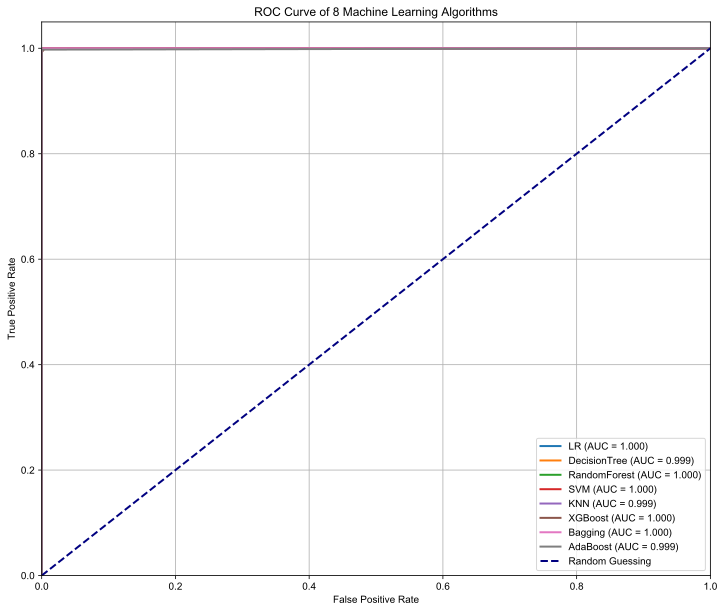

In [20]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(12, 10))

for name, classifier in classifiers.items():
    # Get probability estimates for the positive class
    if hasattr(classifier, "predict_proba"):
        y_score = classifier.predict_proba(X_test_pp)[:, 1]
    else:
        # For classifiers without predict_proba (e.g., SVM with probability=False)
        y_score = classifier.decision_function(X_test_pp)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Guessing")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve of 8 Machine Learning Algorithms")
plt.legend(loc="lower right", bbox_to_anchor=(1.0, 0.0))
plt.grid(True)
plt.show()